In [18]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats
import matplotlib.pyplot as plt
import copy
import sys
import os

# Manually specify the path to the directory containing plot_utility.py
util_path = '/home/austin/Drone_AFRL/util'

# Add the directory to the Python path
sys.path.append(util_path)

# import the function we want from that file
from plot_utility import plot_tme

In [19]:
# System Parameters
m = 0.5 # mass
l = 0.2 # distance from rotor to COM
I = 2/5*m*l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
g = 9.81 # gravity constant

# Control Parameters
tau_k_theta = 10 # torque control to stabilize theta
tau_k_thetadot = 20 # torque control to provide thetadot damping
tau_k_x = 0.01 # torque control to control x position
tau_k_xdot = 0.2 # torque control to provide xdot damping
F_k_z = 1000 # Force control to control z position
F_k_zdot = 10000 # Force control to control z position

F0 = m*g

# Noise for measurements:
v = [0.01, 0.001, 0.2, 0.2]

In [20]:
def desired_trajectory(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.ones_like(t)
    x_des = np.sin(0.01*t)
    return theta_des, x_des, z_des

# Nominal trajectory, measurements

In [21]:
class PlanarDrone:
    def __init__(self):
        self.v = [0.01, 0.001, 0.2, 0.2]

    def control(self, X, t):
        theta, thetadot, x, xdot, z, zdot = X

        # desired trajectory
        theta_des, x_des, z_des = desired_trajectory(t)

        # error
        x_err = x_des - x
        z_err = z_des - z

        # control
        tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
        F = (F_k_z*z_err - F_k_zdot*zdot)

        return F, tau

    def f(self, X, t):
        theta, thetadot, x, xdot, z, zdot = X

        # control
        F, tau = self.control(X, t)

        # dynamics
        d_theta = thetadot
        d_thetadot = tau/I
        d_x = xdot
        d_xdot = -F*np.sin(theta)/m
        d_z = zdot
        d_zdot = (F*np.cos(theta)-m*g)/m

        d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot]

        return d_x

    def h(self, x, v):
        theta, thetadot, x, xdot, z, zdot = x

        y = np.array([theta, thetadot, x, z])

        return y

    def simulate(self, x0, tsim):
        result = odeint(self.f, x0, tsim)
        X = result.T
        U = np.atleast_2d(self.control(X, tsim))
        Y = self.h(X, tsim)
        return X, U, Y

In [22]:
sys = PlanarDrone()

x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]
tsim = np.arange(0, 1000, 0.1)

X, U, Y = sys.simulate(x0, tsim)

In [23]:
print(X.shape)
print(Y.shape)
print(U.shape)

(6, 10000)
(4, 10000)
(2, 10000)


In [24]:
theta = X[0, :]
x = X[2, :]
z = X[4, :]

theta_des, x_des, z_des = desired_trajectory(tsim)

<Axes: xlabel='Time', ylabel='z'>

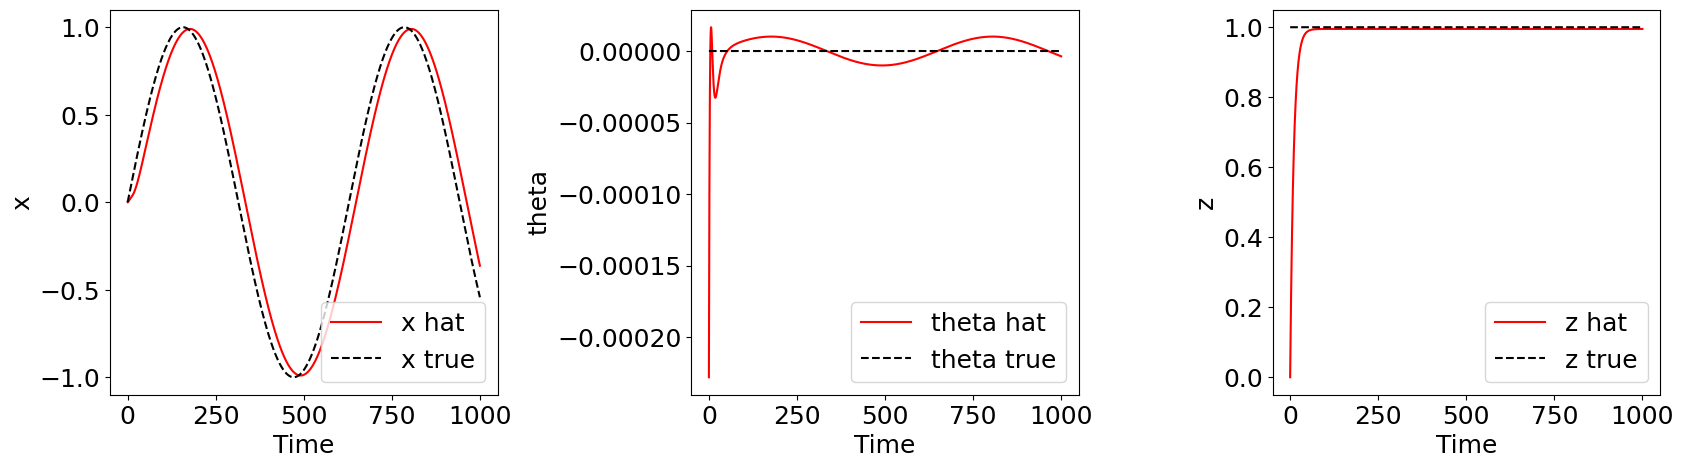

In [25]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(tsim, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(tsim, z_des, None, z, label_var='z', ax=ax3)

Add noise to measurements

In [26]:
v = np.array([0.01, 0.001, 0.2, 0.2])
noise = np.array( [np.random.normal(0, vi, Y.shape[1]) for vi in v] )

In [27]:
Ynoisy = Y + noise

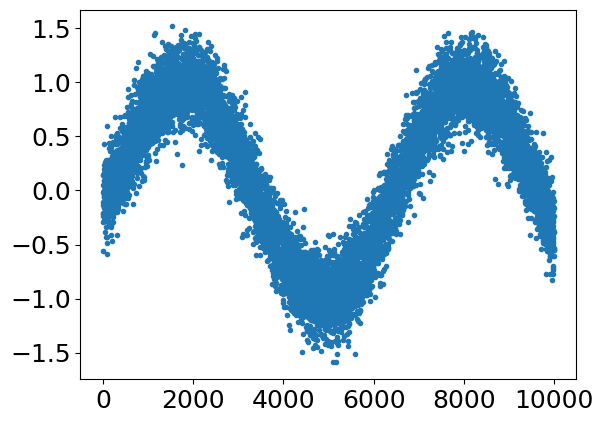

In [28]:
plt.plot(Ynoisy[2,:], '.')

# Initial conditions

In [29]:
# Initial conditions
x0 = np.atleast_2d(np.array([(np.random.random()-0.5)*1e-3 for i in range(6)])).T
P0 = 1000000*np.eye(X.shape[0])

# Noise defined by measurement noise
R = np.diag(v**2)

# Fairly accurate model
Q = 5e-4*np.eye(X.shape[0])

# Extended Kalman Filter

Note: this EKF function expects everything to be given as 2D arrays.

In [31]:
import ekf

In [32]:
def f_d(X, U):
    dt=0.1
    theta, thetadot, x, xdot, z, zdot = np.ravel(X)
    F, tau = np.ravel(U)

    new_theta = theta + thetadot*dt
    new_thetadot = tau/I
    new_x = x + xdot*dt
    new_xdot = -F*np.sin(theta)/m
    new_z = z + zdot*dt
    new_zdot = (F*np.cos(theta)-m*g)/m

    new_x = np.atleast_2d(np.array([new_theta, new_thetadot, new_x, new_xdot, new_z, new_zdot])).T

    return new_x

def h_d(X, U):
    theta, thetadot, x, xdot, z, zdot = np.ravel(X)

    y = np.atleast_2d(np.array([theta, thetadot, x, z])).T

    return y

In [33]:
xhat, P, s = ekf.ekf(Ynoisy, x0, f_d, h_d, Q, R, U)

In [34]:
theta_hat = xhat[0, :]
x_hat = xhat[2, :]
z_hat = xhat[4, :]

<Axes: xlabel='Time', ylabel='z'>

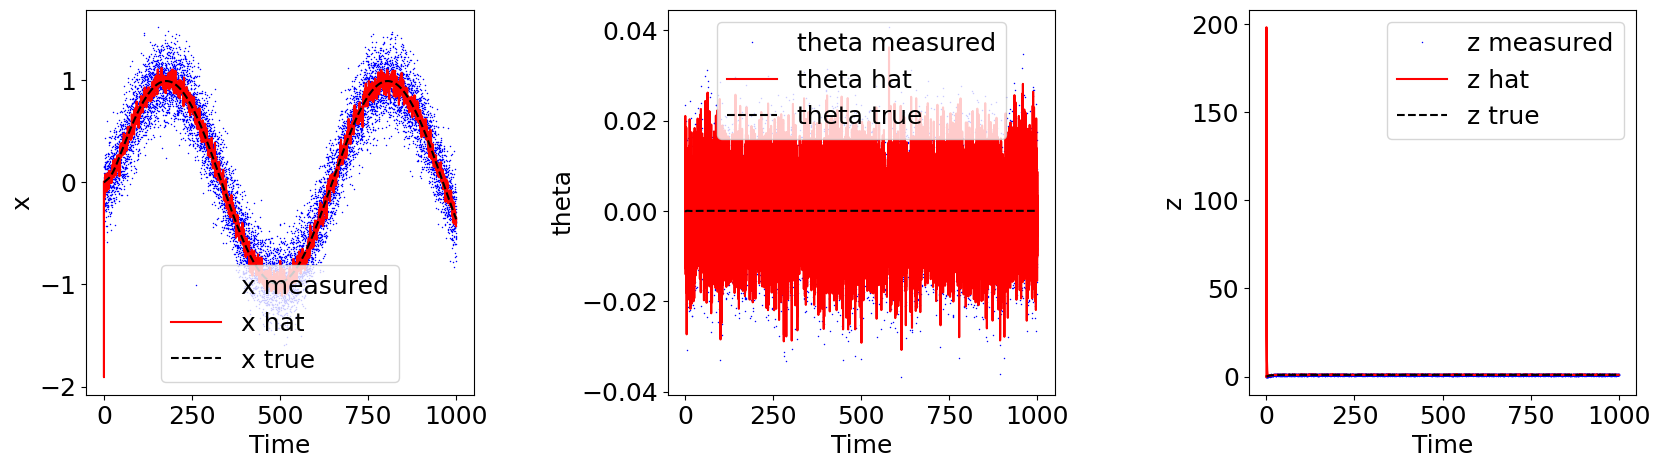

In [35]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, x, Ynoisy[2,:], x_hat, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(tsim, theta, Ynoisy[0,:], theta_hat, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(tsim, z, Ynoisy[3,:], z_hat, label_var='z', ax=ax3)